mid price 概览

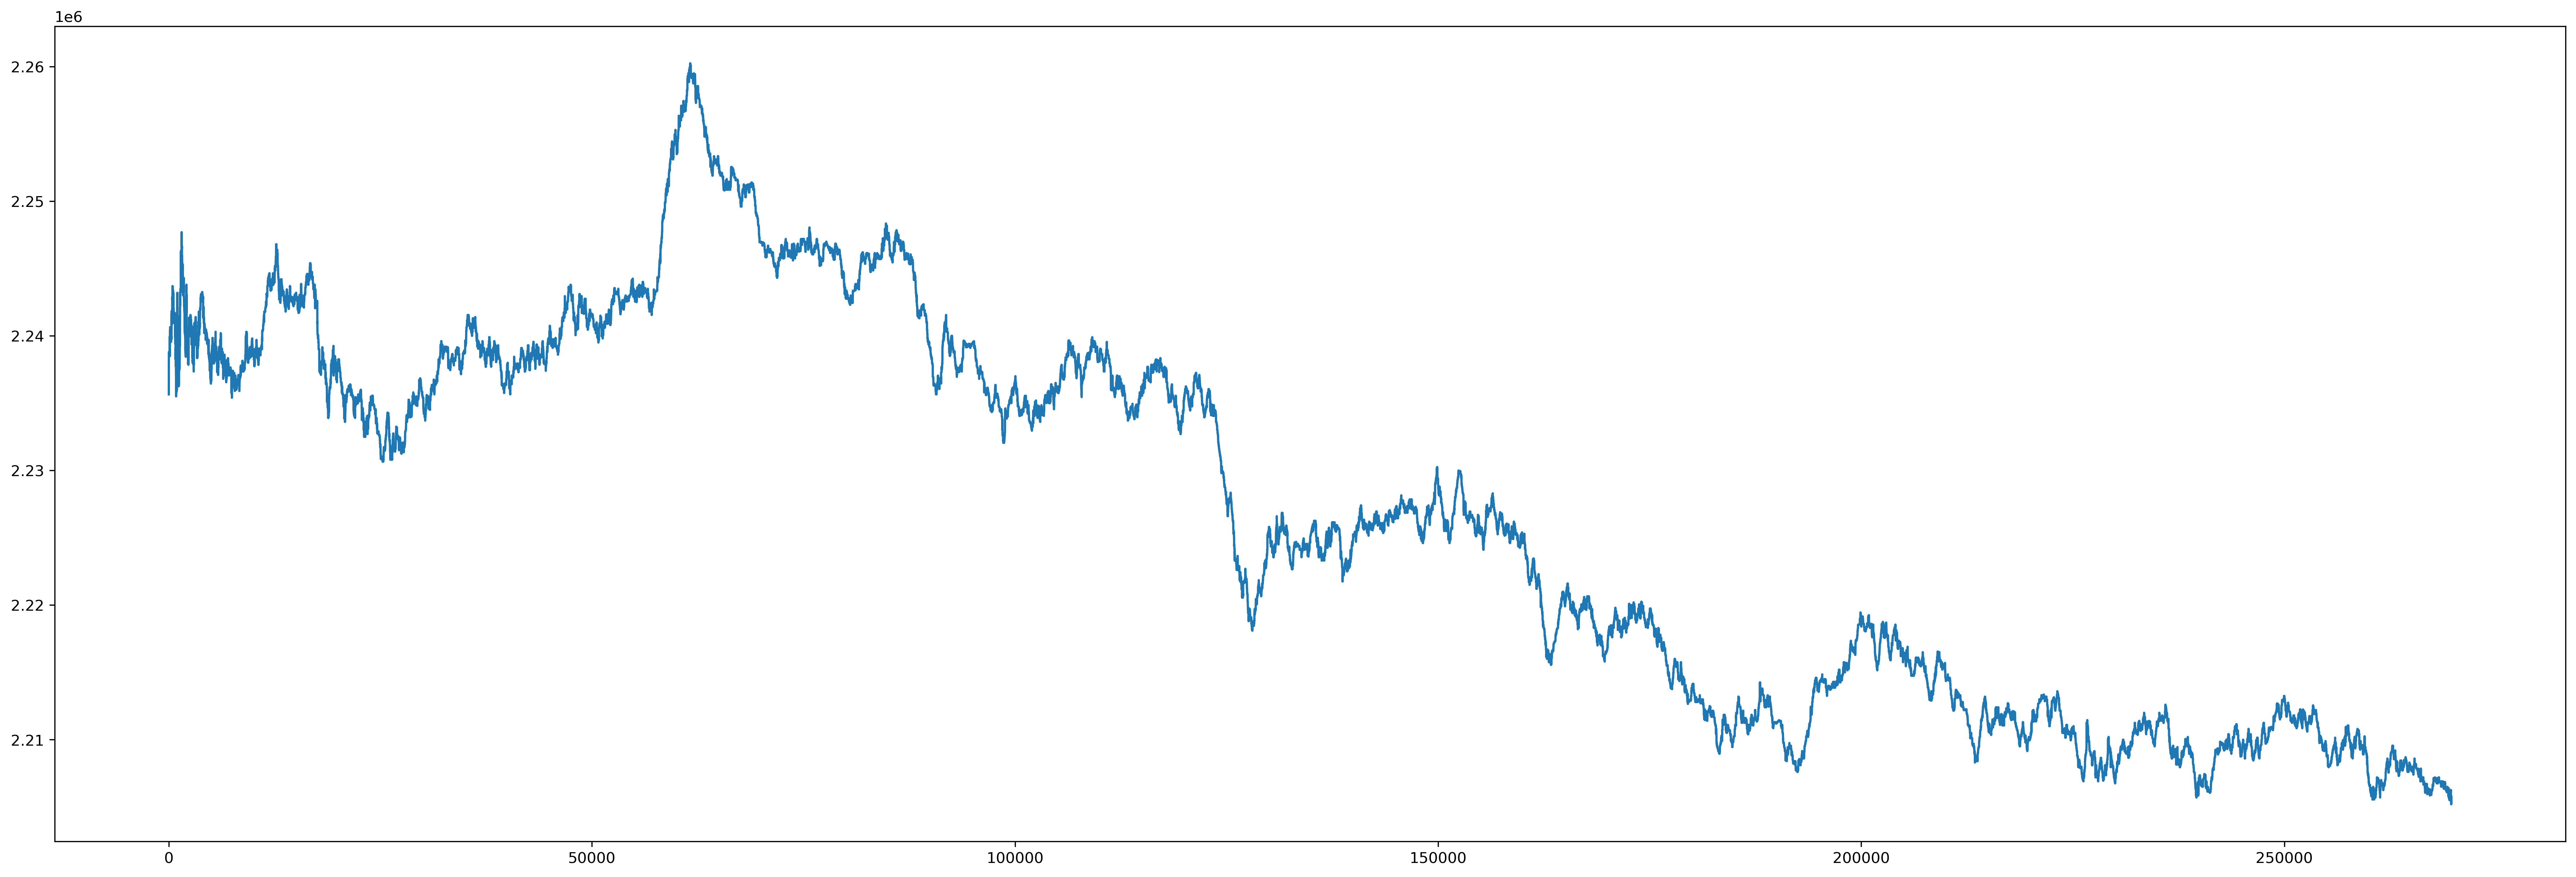

In [18]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
df = pd.read_csv('order.csv')
ask_price = df['ask_price']
bid_price = df['bid_price']
mid_price = (ask_price + bid_price)/2
df['mid'] = mid_price
plt.figure(dpi = 300, figsize = (30,10))
sn.lineplot(data=mid_price)
plt.show()

In [19]:
print(mid_price)

0         2235650.0
1         2238800.0
2         2238800.0
3         2238800.0
4         2238800.0
            ...    
269743    2205650.0
269744    2205750.0
269745    2205750.0
269746    2205700.0
269747    2205750.0
Length: 269748, dtype: float64


In [20]:
df

,ask_price,ask_size,bid_price,bid_size,mid
0,2239500,100,2231800,100,2235650.0
1,2239500,100,2238100,21,2238800.0
2,2239500,100,2238100,21,2238800.0
3,2239500,100,2238100,21,2238800.0
4,2239500,100,2238100,21,2238800.0
...,...,...,...,...,...
269743,2206200,100,2205100,249,2205650.0
269744,2206400,100,2205100,249,2205750.0
269745,2206400,100,2205100,249,2205750.0
269746,2206300,100,2205100,249,2205700.0


midprice在5000个单位上的缩放图

0       2235650.0
1       2238800.0
2       2238800.0
3       2238800.0
4       2238800.0
          ...    
4995    2236700.0
4996    2236700.0
4997    2236700.0
4998    2236700.0
4999    2236700.0
Length: 5000, dtype: float64


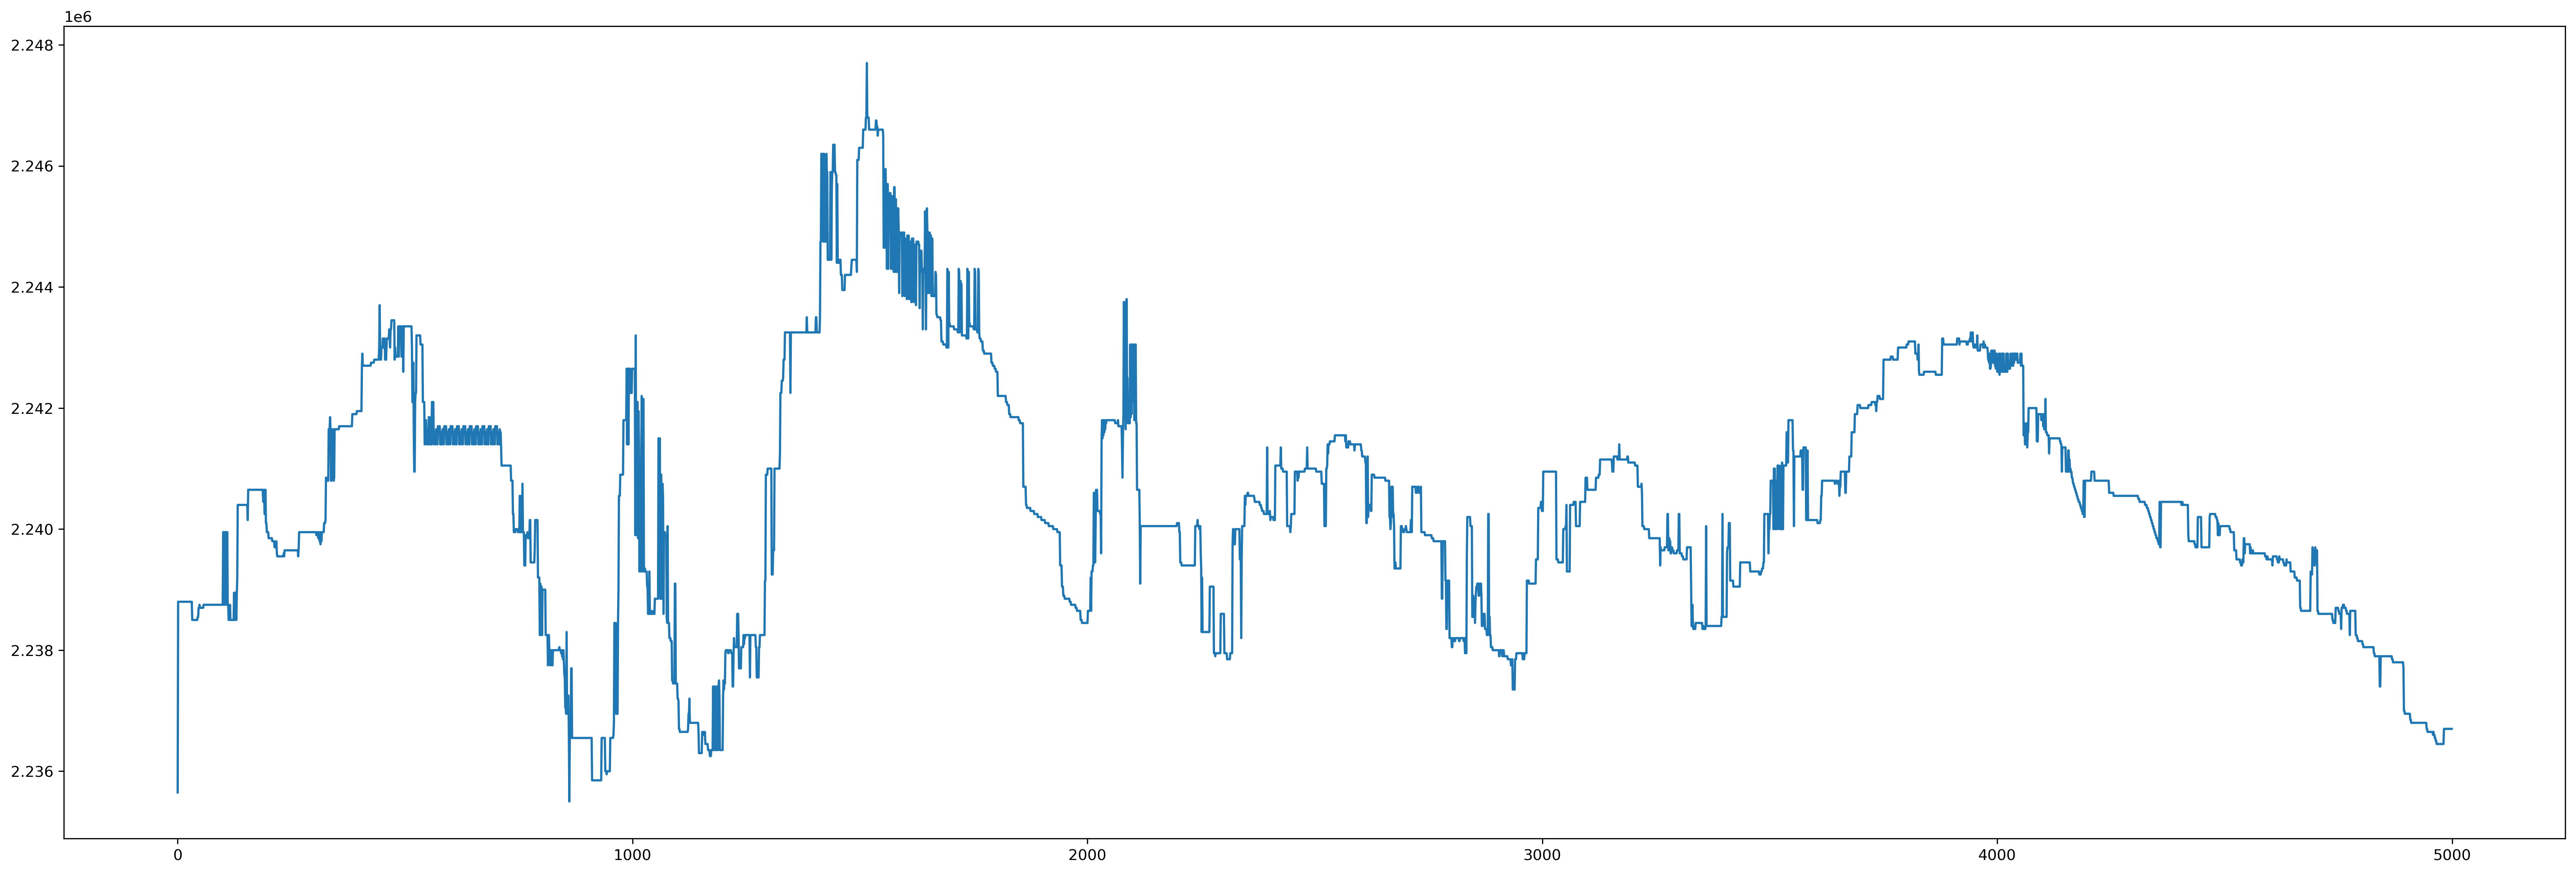

In [22]:
min_mid = mid_price[:5000]
print(min_mid)
plt.figure(dpi = 300, figsize = (30,10))
sn.lineplot(data=min_mid)
plt.show()

假设midprice作为一个变量x，x仅被时序和x本身所解释（X单纯拥有markov性质）。且x在时间T上仅仅与[X_{T-500}，X_T]有关（这里简化我们的分析过程，让num：n仅仅为500） 
建立线性回归模型， X=[1,500]为时序，y=[前一百个mid_price] 然后预测T+1上的值。根据当前价和预测值进行多空操作，统计后m个序列中是否会盈利（m暂定50）

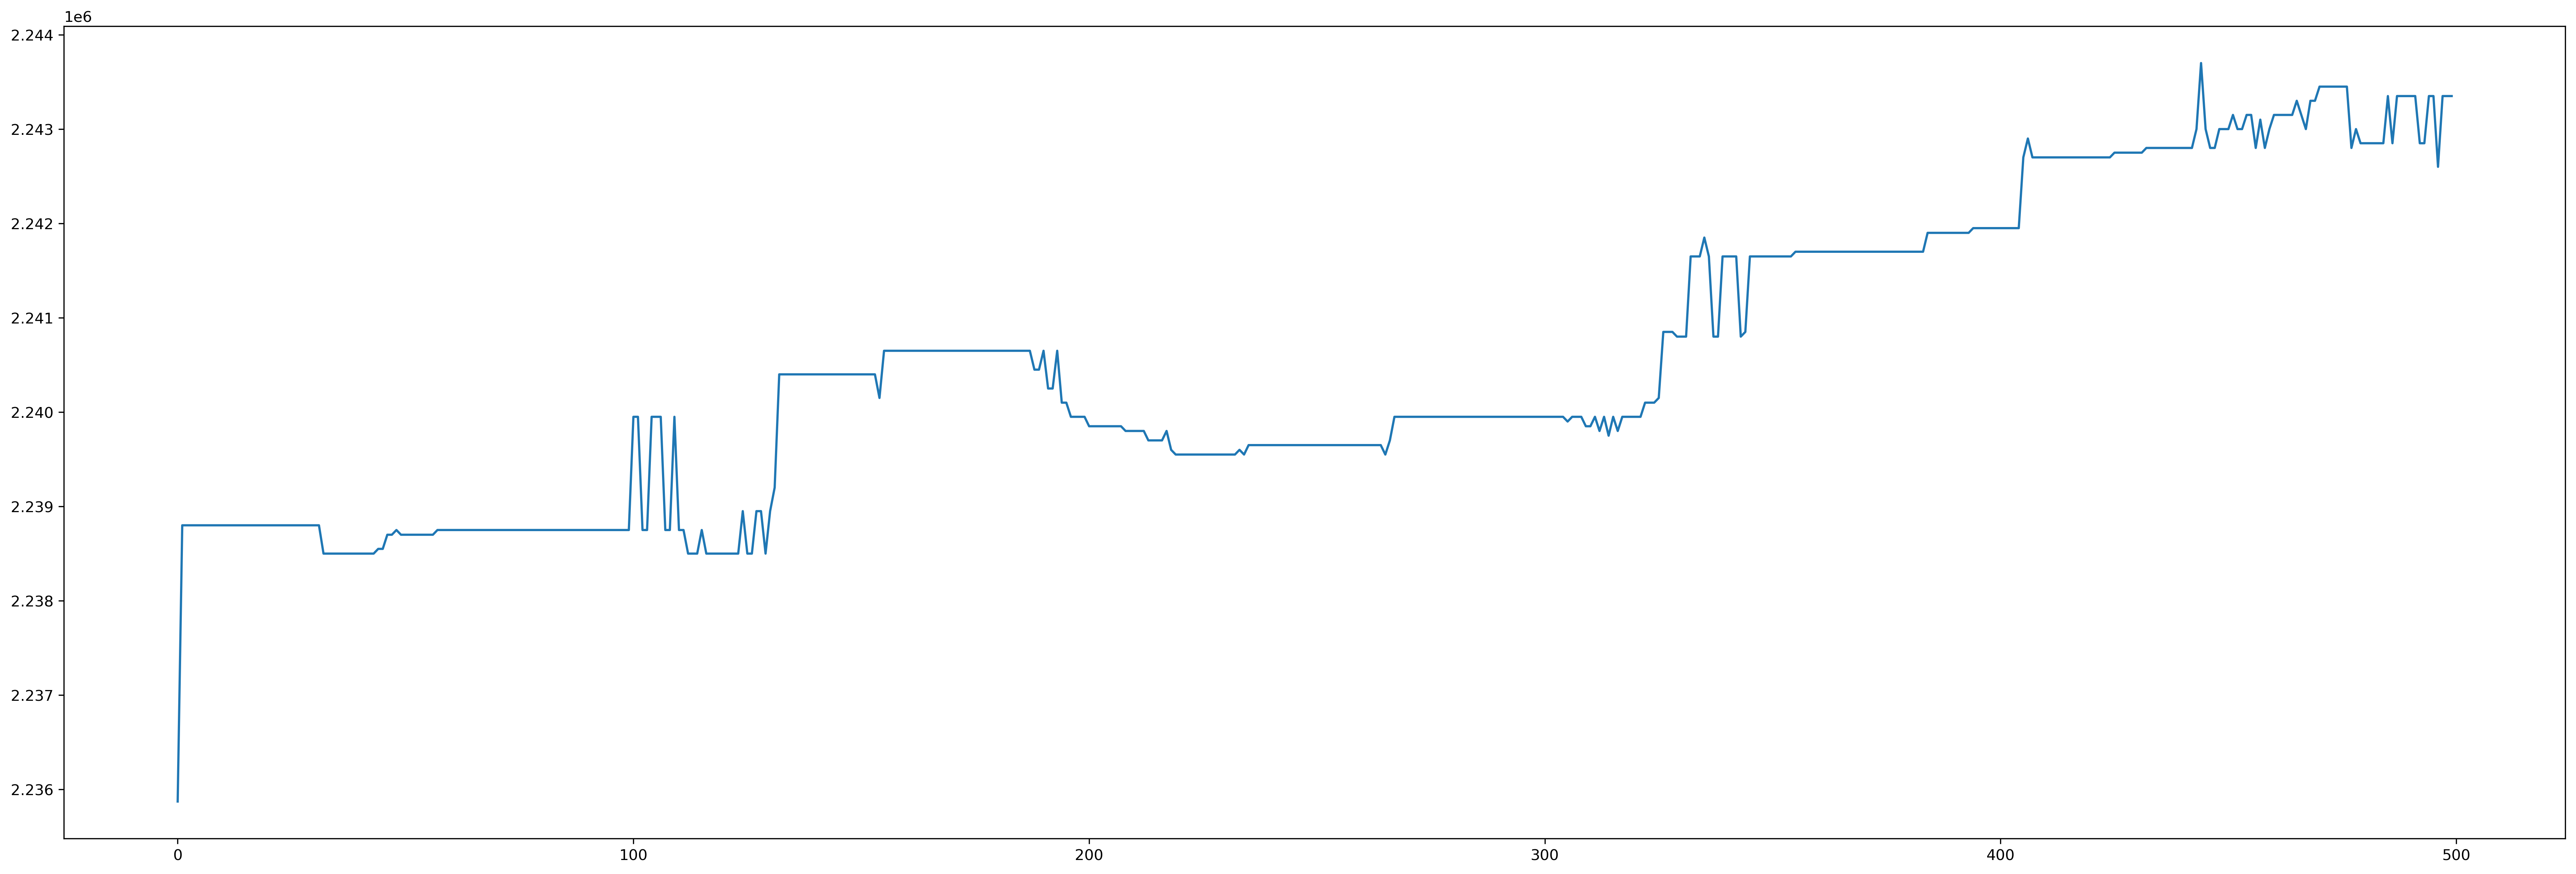

0      2.235872e+06
1      2.238800e+06
2      2.238800e+06
3      2.238800e+06
4      2.238800e+06
           ...     
495    2.243350e+06
496    2.242600e+06
497    2.243350e+06
498    2.243350e+06
499    2.243350e+06
Length: 500, dtype: float64
current price  2243350.0
predict price  [2243429.26127444]


In [62]:
def filter_extreme_3sigma(data,n=3,times=3): 
    # times进行times次3sigma处理 去极值
    series = data.copy()
    for i in range(times):
        mean = series.mean()
        std = series.std()
        max_range = mean + n*std
        min_range = mean - n*std
        series = np.clip(series,min_range,max_range)
    return series

from sklearn.linear_model import LinearRegression

X = np.arange(0,500,1).reshape(-1, 1)
y = mid_price[:500]
y = filter_extreme_3sigma(y)
plt.figure(dpi = 300, figsize = (30,10))
sn.lineplot(data=y)
plt.show()
print(y)
reg = LinearRegression().fit(X, y)
print("current price ", mid_price[500]) # 当前
print("predict price ", reg.predict([[550]]))


In [61]:
wait = mid_price[500:550]
wait 

500    2243350.0
501    2243350.0
502    2243350.0
503    2243350.0
504    2243350.0
505    2243350.0
506    2243350.0
507    2243350.0
508    2243350.0
509    2243350.0
510    2243350.0
511    2243350.0
512    2243350.0
513    2243350.0
514    2243350.0
515    2243000.0
516    2242100.0
517    2242100.0
518    2242750.0
519    2241600.0
520    2240950.0
521    2240950.0
522    2242100.0
523    2242250.0
524    2242250.0
525    2243200.0
526    2243200.0
527    2243200.0
528    2243200.0
529    2243200.0
530    2243200.0
531    2243200.0
532    2243200.0
533    2243200.0
534    2243050.0
535    2243050.0
536    2243050.0
537    2243050.0
538    2243050.0
539    2242100.0
540    2242100.0
541    2242100.0
542    2242100.0
543    2241400.0
544    2241800.0
545    2241800.0
546    2241800.0
547    2241400.0
548    2241650.0
549    2241650.0
dtype: float64

2243429.26127444 高于 2239950.0值（当前值）按照预测结果则会做多 从后面的50个mid_price来看这一次交易是有效的
为了进一步分析可行性，我们统计随机tick上一千次尝试中盈亏（实际上在一千次里做回测）止盈定在预测值附近200以内 止损定在50个tick上

In [63]:
am = 0 # 总盈利
for i in range(1000):
    X = np.arange(0,500,1).reshape(-1, 1)
    y = mid_price[:500]
    y = filter_extreme_3sigma(y)
# plt.figure(dpi = 300, figsize = (30,10))
# sn.lineplot(data=y)
# plt.show()
# print(y)
    reg = LinearRegression().fit(X, y)
    predit = reg.predict([[500]])
    current = mid_price[i+500]
    # 计算return(包括止盈止损)
    wait = mid_price[i+500:i+550].tolist()
    flag = predit - current
    ret = 0
    if flag > 0:
        for x in wait:
            if x > predit - 200:
                ret = x - current
                print("做多：", ret)
                break
        if ret == 0:
            ret =wait[-1] - current
            print("做多：", ret)
    if flag < 0:
        for x in wait:
            if x < predit + 200:
                ret = current - x 
                print("做空：", ret)
                break
        if ret == 0:
            ret =  current - wait[-1]
            print("做空：", ret)
        
    if flag == 0:
        continue
    am = am + ret
    print("总盈利",am)
        
            
am
        
# print(reg.predict([[100]]))
# print(mid_price[101])

做空： 350.0
总盈利 350.0
做空： 350.0
总盈利 700.0
做空： 350.0
总盈利 1050.0
做空： 350.0
总盈利 1400.0
做空： 350.0
总盈利 1750.0
做空： 350.0
总盈利 2100.0
做空： 350.0
总盈利 2450.0
做空： 350.0
总盈利 2800.0
做空： 350.0
总盈利 3150.0
做空： 350.0
总盈利 3500.0
做空： 350.0
总盈利 3850.0
做空： 350.0
总盈利 4200.0
做空： 350.0
总盈利 4550.0
做空： 350.0
总盈利 4900.0
做空： 350.0
总盈利 5250.0
做空： 0.0
做空： 1400.0
总盈利 6650.0
做多： 650.0
总盈利 7300.0
做多： 650.0
总盈利 7950.0
做多： 0.0
做多： -1350.0
总盈利 6600.0
做多： 1600.0
总盈利 8200.0
做多： 2250.0
总盈利 10450.0
做多： 2250.0
总盈利 12700.0
做多： 1100.0
总盈利 13800.0
做多： 950.0
总盈利 14750.0
做多： 950.0
总盈利 15700.0
做空： 150.0
总盈利 15850.0
做空： 150.0
总盈利 16000.0
做空： 150.0
总盈利 16150.0
做空： 150.0
总盈利 16300.0
做空： 150.0
总盈利 16450.0
做空： 150.0
总盈利 16600.0
做空： 150.0
总盈利 16750.0
做空： 150.0
总盈利 16900.0
做空： 150.0
总盈利 17050.0
做空： 0.0
做空： 1400.0
总盈利 18450.0
做空： 0.0
做空： 1400.0
总盈利 19850.0
做空： 0.0
做空： 1650.0
总盈利 21500.0
做空： 0.0
做空： 1350.0
总盈利 22850.0
做空： 0.0
做空： 1350.0
总盈利 24200.0
做多： -400.0
总盈利 23800.0
做多： -400.0
总盈利 23400.0
做多： -400.0
总盈利 23000.0
做多： -700.0
总盈利 22300.0
做多： 

做多： -700.0
总盈利 -239500.0
做多： -700.0
总盈利 -240200.0
做多： -700.0
总盈利 -240900.0
做多： -700.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： -550.0
总盈利 -242150.0
做多： -550.0
总盈利 -242700.0
做多： -550.0
总盈利 -243250.0
做多： -600.0
总盈利 -243850.0
做多： -550.0
总盈利 -244400.0
做多： -550.0
总盈利 -244950.0
做多： -550.0
总盈利 -245500.0
做多： -550.0
总盈利 -246050.0
做多： -550.0
总盈利 -246600.0
做多： -550.0
总盈利 -247150.0
做多： -550.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 50.0
总盈利 -247650.0
做多： 250.0
总盈利 -247400.0
做多： 2600.0
总盈利 -244800.0
做多： 2600.0
总盈利 -242200.0
做多： 2600.0
总盈利 -239600.0
做多： 2600.0
总盈利 -237000.0
做多： 1100.0
总盈利 -235900.0
做多： 1100.0
总盈利 -234800.0
做多： 1100.0
总盈利 -233700.0
做多： 1100.0
总盈利 -232600.0
做多： 2600.0
总盈利 -230000.0
做多： 3150.0
总盈利 -226850.

做多： 1400.0
总盈利 71500.0
做多： 1400.0
总盈利 72900.0
做多： 1400.0
总盈利 74300.0
做多： 2750.0
总盈利 77050.0
做多： 2750.0
总盈利 79800.0
做多： 2750.0
总盈利 82550.0
做多： 2750.0
总盈利 85300.0
做多： 2750.0
总盈利 88050.0
做多： 2750.0
总盈利 90800.0
做多： 2750.0
总盈利 93550.0
做多： 2750.0
总盈利 96300.0
做多： 2950.0
总盈利 99250.0
做多： 2950.0
总盈利 102200.0
做多： 3450.0
总盈利 105650.0
做多： 3450.0
总盈利 109100.0
做多： 3700.0
总盈利 112800.0
做多： 4700.0
总盈利 117500.0
做多： 4700.0
总盈利 122200.0
做多： 4200.0
总盈利 126400.0
做多： 4400.0
总盈利 130800.0
做多： 4200.0
总盈利 135000.0
做多： 4200.0
总盈利 139200.0
做多： 4250.0
总盈利 143450.0
做多： 4550.0
总盈利 148000.0
做多： 4550.0
总盈利 152550.0
做多： 4550.0
总盈利 157100.0
做多： 4550.0
总盈利 161650.0
做多： 4550.0
总盈利 166200.0
做多： 4550.0
总盈利 170750.0
做多： 4550.0
总盈利 175300.0
做多： 4550.0
总盈利 179850.0
做多： 3650.0
总盈利 183500.0
做多： 3650.0
总盈利 187150.0
做多： 1900.0
总盈利 189050.0
做多： 1900.0
总盈利 190950.0
做多： 1900.0
总盈利 192850.0
做多： 1900.0
总盈利 194750.0
做多： 1800.0
总盈利 196550.0
做多： 1800.0
总盈利 198350.0
做多： 1800.0
总盈利 200150.0
做多： 1800.0
总盈利 201950.0
做多： 1800.0
总盈利 203750.0
做多： 

107400.0

下面试试一万个tick上的预测盈亏

In [64]:
am = 0 # 总盈利
for i in range(10000):
    X = np.arange(0,500,1).reshape(-1, 1)
    y = mid_price[:500]
    y = filter_extreme_3sigma(y)
    reg = LinearRegression().fit(X, y)
    predit = reg.predict([[500]])
    current = mid_price[i+500]
    # 计算return(包括止盈止损)
    wait = mid_price[i+500:i+550].tolist()
    flag = predit - current
    ret = 0
    if flag > 0:
        for x in wait:
            if x > predit - 200:
                ret = x - current
                print("做多：", ret)
                break
        if ret == 0:
            ret =wait[-1] - current
            print("做多：", ret)
    if flag < 0:
        for x in wait:
            if x < predit + 200:
                ret = current - x 
                print("做空：", ret)
                break
        if ret == 0:
            ret =  current - wait[-1]
            print("做空：", ret)
        
    if flag == 0:
        continue
    am = am + ret
    print("总盈利",am)
        
            
am
        


做空： 350.0
总盈利 350.0
做空： 350.0
总盈利 700.0
做空： 350.0
总盈利 1050.0
做空： 350.0
总盈利 1400.0
做空： 350.0
总盈利 1750.0
做空： 350.0
总盈利 2100.0
做空： 350.0
总盈利 2450.0
做空： 350.0
总盈利 2800.0
做空： 350.0
总盈利 3150.0
做空： 350.0
总盈利 3500.0
做空： 350.0
总盈利 3850.0
做空： 350.0
总盈利 4200.0
做空： 350.0
总盈利 4550.0
做空： 350.0
总盈利 4900.0
做空： 350.0
总盈利 5250.0
做空： 0.0
做空： 1400.0
总盈利 6650.0
做多： 650.0
总盈利 7300.0
做多： 650.0
总盈利 7950.0
做多： 0.0
做多： -1350.0
总盈利 6600.0
做多： 1600.0
总盈利 8200.0
做多： 2250.0
总盈利 10450.0
做多： 2250.0
总盈利 12700.0
做多： 1100.0
总盈利 13800.0
做多： 950.0
总盈利 14750.0
做多： 950.0
总盈利 15700.0
做空： 150.0
总盈利 15850.0
做空： 150.0
总盈利 16000.0
做空： 150.0
总盈利 16150.0
做空： 150.0
总盈利 16300.0
做空： 150.0
总盈利 16450.0
做空： 150.0
总盈利 16600.0
做空： 150.0
总盈利 16750.0
做空： 150.0
总盈利 16900.0
做空： 150.0
总盈利 17050.0
做空： 0.0
做空： 1400.0
总盈利 18450.0
做空： 0.0
做空： 1400.0
总盈利 19850.0
做空： 0.0
做空： 1650.0
总盈利 21500.0
做空： 0.0
做空： 1350.0
总盈利 22850.0
做空： 0.0
做空： 1350.0
总盈利 24200.0
做多： -400.0
总盈利 23800.0
做多： -400.0
总盈利 23400.0
做多： -400.0
总盈利 23000.0
做多： -700.0
总盈利 22300.0
做多： 

做多： -700.0
总盈利 -238100.0
做多： -700.0
总盈利 -238800.0
做多： -700.0
总盈利 -239500.0
做多： -700.0
总盈利 -240200.0
做多： -700.0
总盈利 -240900.0
做多： -700.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： 0.0
总盈利 -241600.0
做多： -550.0
总盈利 -242150.0
做多： -550.0
总盈利 -242700.0
做多： -550.0
总盈利 -243250.0
做多： -600.0
总盈利 -243850.0
做多： -550.0
总盈利 -244400.0
做多： -550.0
总盈利 -244950.0
做多： -550.0
总盈利 -245500.0
做多： -550.0
总盈利 -246050.0
做多： -550.0
总盈利 -246600.0
做多： -550.0
总盈利 -247150.0
做多： -550.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 0.0
总盈利 -247700.0
做多： 50.0
总盈利 -247650.0
做多： 250.0
总盈利 -247400.0
做多： 2600.0
总盈利 -244800.0
做多： 2600.0
总盈利 -242200.0
做多： 2600.0
总盈利 -239600.0
做多： 2600.0
总盈利 -237000.0
做多： 1100.0
总盈利 -235900.0
做多： 1100.0
总盈利 -234800.0
做多： 1100.0
总盈利 -233700.0
做多： 1100.0
总盈利 -232600.

做多： -350.0
总盈利 25300.0
做多： 0.0
总盈利 25300.0
做多： 550.0
总盈利 25850.0
做多： 550.0
总盈利 26400.0
做多： 550.0
总盈利 26950.0
做多： 550.0
总盈利 27500.0
做多： 550.0
总盈利 28050.0
做多： 200.0
总盈利 28250.0
做多： 200.0
总盈利 28450.0
做多： 200.0
总盈利 28650.0
做多： 1100.0
总盈利 29750.0
做多： 1100.0
总盈利 30850.0
做多： 2650.0
总盈利 33500.0
做多： 2800.0
总盈利 36300.0
做多： 2650.0
总盈利 38950.0
做多： 2700.0
总盈利 41650.0
做多： 2750.0
总盈利 44400.0
做多： 2750.0
总盈利 47150.0
做多： 2750.0
总盈利 49900.0
做多： 2750.0
总盈利 52650.0
做多： 2750.0
总盈利 55400.0
做多： 2750.0
总盈利 58150.0
做多： 2750.0
总盈利 60900.0
做多： 2750.0
总盈利 63650.0
做多： 2750.0
总盈利 66400.0
做多： 1000.0
总盈利 67400.0
做多： 1700.0
总盈利 69100.0
做多： 1000.0
总盈利 70100.0
做多： 1400.0
总盈利 71500.0
做多： 1400.0
总盈利 72900.0
做多： 1400.0
总盈利 74300.0
做多： 2750.0
总盈利 77050.0
做多： 2750.0
总盈利 79800.0
做多： 2750.0
总盈利 82550.0
做多： 2750.0
总盈利 85300.0
做多： 2750.0
总盈利 88050.0
做多： 2750.0
总盈利 90800.0
做多： 2750.0
总盈利 93550.0
做多： 2750.0
总盈利 96300.0
做多： 2950.0
总盈利 99250.0
做多： 2950.0
总盈利 102200.0
做多： 3450.0
总盈利 105650.0
做多： 3450.0
总盈利 109100.0
做多： 3700.0
总盈利 1128

做空： 600.0
总盈利 204800.0
做空： 600.0
总盈利 205400.0
做空： -350.0
总盈利 205050.0
做空： 700.0
总盈利 205750.0
做空： 350.0
总盈利 206100.0
做空： -700.0
总盈利 205400.0
做空： 650.0
总盈利 206050.0
做空： 650.0
总盈利 206700.0
做空： 1600.0
总盈利 208300.0
做空： 600.0
总盈利 208900.0
做空： 550.0
总盈利 209450.0
做空： 600.0
总盈利 210050.0
做空： -450.0
总盈利 209600.0
做空： -350.0
总盈利 209250.0
做空： 600.0
总盈利 209850.0
做空： 1600.0
总盈利 211450.0
做空： 550.0
总盈利 212000.0
做空： -1450.0
总盈利 210550.0
做空： -150.0
总盈利 210400.0
做空： 900.0
总盈利 211300.0
做空： -150.0
总盈利 211150.0
做空： -150.0
总盈利 211000.0
做空： -100.0
总盈利 210900.0
做空： -50.0
总盈利 210850.0
做空： 0.0
总盈利 210850.0
做空： 0.0
总盈利 210850.0
做空： 0.0
总盈利 210850.0
做空： -50.0
总盈利 210800.0
做空： -50.0
总盈利 210750.0
做空： -50.0
总盈利 210700.0
做空： 850.0
总盈利 211550.0
做空： 850.0
总盈利 212400.0
做空： -100.0
总盈利 212300.0
做空： 950.0
总盈利 213250.0
做空： 950.0
总盈利 214200.0
做空： 950.0
总盈利 215150.0
做空： 550.0
总盈利 215700.0
做空： -450.0
总盈利 215250.0
做空： 1150.0
总盈利 216400.0
做空： 1150.0
总盈利 217550.0
做空： 1150.0
总盈利 218700.0
做空： 1150.0
总盈利 219850.0
做空： 200.0
总盈利 220050.0

做多： -600.0
总盈利 112550.0
做多： -600.0
总盈利 111950.0
做多： -600.0
总盈利 111350.0
做多： -450.0
总盈利 110900.0
做多： -450.0
总盈利 110450.0
做多： -450.0
总盈利 110000.0
做多： -400.0
总盈利 109600.0
做多： -400.0
总盈利 109200.0
做多： -200.0
总盈利 109000.0
做多： -200.0
总盈利 108800.0
做多： -200.0
总盈利 108600.0
做多： -200.0
总盈利 108400.0
做多： -200.0
总盈利 108200.0
做多： -200.0
总盈利 108000.0
做多： 350.0
总盈利 108350.0
做多： -200.0
总盈利 108150.0
做多： 450.0
总盈利 108600.0
做多： 500.0
总盈利 109100.0
做多： 500.0
总盈利 109600.0
做多： 600.0
总盈利 110200.0
做多： 650.0
总盈利 110850.0
做多： 1850.0
总盈利 112700.0
做多： 1850.0
总盈利 114550.0
做多： 1350.0
总盈利 115900.0
做多： 700.0
总盈利 116600.0
做多： 1400.0
总盈利 118000.0
做多： 1900.0
总盈利 119900.0
做多： 1700.0
总盈利 121600.0
做多： 1900.0
总盈利 123500.0
做多： 1550.0
总盈利 125050.0
做多： 1600.0
总盈利 126650.0
做多： 1600.0
总盈利 128250.0
做多： 1600.0
总盈利 129850.0
做多： 1650.0
总盈利 131500.0
做多： 1650.0
总盈利 133150.0
做多： 1600.0
总盈利 134750.0
做多： 1650.0
总盈利 136400.0
做多： 950.0
总盈利 137350.0
做多： 2800.0
总盈利 140150.0
做多： 3150.0
总盈利 143300.0
做多： 2850.0
总盈利 146150.0
做多： 3300.0
总盈利 149450.0


做多： 1800.0
总盈利 352750.0
做多： 1950.0
总盈利 354700.0
做多： 1950.0
总盈利 356650.0
做多： 2600.0
总盈利 359250.0
做多： 2600.0
总盈利 361850.0
做多： 2650.0
总盈利 364500.0
做多： 2650.0
总盈利 367150.0
做多： 2600.0
总盈利 369750.0
做多： 2600.0
总盈利 372350.0
做多： 2700.0
总盈利 375050.0
做多： 2700.0
总盈利 377750.0
做多： 2700.0
总盈利 380450.0
做多： 2700.0
总盈利 383150.0
做多： 2700.0
总盈利 385850.0
做多： 2700.0
总盈利 388550.0
做多： 2700.0
总盈利 391250.0
做多： 2600.0
总盈利 393850.0
做多： 2600.0
总盈利 396450.0
做多： 2600.0
总盈利 399050.0
做多： 2600.0
总盈利 401650.0
做多： 2550.0
总盈利 404200.0
做多： 700.0
总盈利 404900.0
做多： 450.0
总盈利 405350.0
做多： 450.0
总盈利 405800.0
做多： 700.0
总盈利 406500.0
做多： 700.0
总盈利 407200.0
做多： 700.0
总盈利 407900.0
做多： 450.0
总盈利 408350.0
做多： 450.0
总盈利 408800.0
做多： 450.0
总盈利 409250.0
做多： 450.0
总盈利 409700.0
做多： 450.0
总盈利 410150.0
做多： 400.0
总盈利 410550.0
做多： 400.0
总盈利 410950.0
做多： 400.0
总盈利 411350.0
做多： 350.0
总盈利 411700.0
做多： 350.0
总盈利 412050.0
做多： 800.0
总盈利 412850.0
做多： 800.0
总盈利 413650.0
做多： 800.0
总盈利 414450.0
做多： 2100.0
总盈利 416550.0
做多： 750.0
总盈利 417300.0
做多： 200.0
总盈

做多： -850.0
总盈利 403800.0
做多： -850.0
总盈利 402950.0
做多： -850.0
总盈利 402100.0
做多： -800.0
总盈利 401300.0
做多： -850.0
总盈利 400450.0
做多： -900.0
总盈利 399550.0
做多： -900.0
总盈利 398650.0
做多： -850.0
总盈利 397800.0
做多： -850.0
总盈利 396950.0
做多： -850.0
总盈利 396100.0
做多： -850.0
总盈利 395250.0
做多： -850.0
总盈利 394400.0
做多： -850.0
总盈利 393550.0
做多： -850.0
总盈利 392700.0
做多： -650.0
总盈利 392050.0
做多： -650.0
总盈利 391400.0
做多： -250.0
总盈利 391150.0
做多： 500.0
总盈利 391650.0
做多： 700.0
总盈利 392350.0
做多： 600.0
总盈利 392950.0
做多： 0.0
总盈利 392950.0
做多： 0.0
总盈利 392950.0
做多： 0.0
总盈利 392950.0
做多： 0.0
总盈利 392950.0
做多： 500.0
总盈利 393450.0
做多： 350.0
总盈利 393800.0
做多： 550.0
总盈利 394350.0
做多： 1250.0
总盈利 395600.0
做多： 1350.0
总盈利 396950.0
做多： 1250.0
总盈利 398200.0
做多： 1350.0
总盈利 399550.0
做多： 1350.0
总盈利 400900.0
做多： 1250.0
总盈利 402150.0
做多： 1250.0
总盈利 403400.0
做多： 1250.0
总盈利 404650.0
做多： 1250.0
总盈利 405900.0
做多： 1350.0
总盈利 407250.0
做多： 600.0
总盈利 407850.0
做多： 600.0
总盈利 408450.0
做多： 600.0
总盈利 409050.0
做多： 600.0
总盈利 409650.0
做多： -100.0
总盈利 409550.0
做多： -100.0
总盈利

做多： -500.0
总盈利 395400.0
做多： -900.0
总盈利 394500.0
做多： -900.0
总盈利 393600.0
做多： -900.0
总盈利 392700.0
做多： -900.0
总盈利 391800.0
做多： -900.0
总盈利 390900.0
做多： -900.0
总盈利 390000.0
做多： 550.0
总盈利 390550.0
做多： 550.0
总盈利 391100.0
做多： 550.0
总盈利 391650.0
做多： 950.0
总盈利 392600.0
做多： 1000.0
总盈利 393600.0
做多： 1000.0
总盈利 394600.0
做多： 1000.0
总盈利 395600.0
做多： 1000.0
总盈利 396600.0
做多： 1000.0
总盈利 397600.0
做多： 1000.0
总盈利 398600.0
做多： 1000.0
总盈利 399600.0
做多： 1000.0
总盈利 400600.0
做多： 1000.0
总盈利 401600.0
做多： 1000.0
总盈利 402600.0
做多： 1000.0
总盈利 403600.0
做多： 850.0
总盈利 404450.0
做多： 850.0
总盈利 405300.0
做多： 850.0
总盈利 406150.0
做多： 850.0
总盈利 407000.0
做多： 650.0
总盈利 407650.0
做多： 600.0
总盈利 408250.0
做多： 600.0
总盈利 408850.0
做多： 250.0
总盈利 409100.0
做多： 1350.0
总盈利 410450.0
做多： 1350.0
总盈利 411800.0
做多： 1350.0
总盈利 413150.0
做多： 1350.0
总盈利 414500.0
做多： 1350.0
总盈利 415850.0
做多： 1350.0
总盈利 417200.0
做多： 1350.0
总盈利 418550.0
做多： 250.0
总盈利 418800.0
做多： 250.0
总盈利 419050.0
做多： 250.0
总盈利 419300.0
做多： 250.0
总盈利 419550.0
做多： 250.0
总盈利 419800.0
做多： 250.0

做多： 650.0
总盈利 345050.0
做多： 650.0
总盈利 345700.0
做多： 650.0
总盈利 346350.0
做多： 650.0
总盈利 347000.0
做多： 1050.0
总盈利 348050.0
做多： 1050.0
总盈利 349100.0
做多： 1050.0
总盈利 350150.0
做多： 1050.0
总盈利 351200.0
做多： 1050.0
总盈利 352250.0
做多： 1050.0
总盈利 353300.0
做多： 1050.0
总盈利 354350.0
做多： 1050.0
总盈利 355400.0
做多： 900.0
总盈利 356300.0
做多： 900.0
总盈利 357200.0
做多： -800.0
总盈利 356400.0
做多： 900.0
总盈利 357300.0
做多： 900.0
总盈利 358200.0
做多： 900.0
总盈利 359100.0
做多： 900.0
总盈利 360000.0
做多： 900.0
总盈利 360900.0
做多： 900.0
总盈利 361800.0
做多： 900.0
总盈利 362700.0
做多： 900.0
总盈利 363600.0
做多： 900.0
总盈利 364500.0
做多： -150.0
总盈利 364350.0
做多： -250.0
总盈利 364100.0
做多： -400.0
总盈利 363700.0
做多： -400.0
总盈利 363300.0
做多： -800.0
总盈利 362500.0
做多： -800.0
总盈利 361700.0
做多： -800.0
总盈利 360900.0
做多： 150.0
总盈利 361050.0
做多： 150.0
总盈利 361200.0
做多： 150.0
总盈利 361350.0
做多： 150.0
总盈利 361500.0
做多： 150.0
总盈利 361650.0
做多： 150.0
总盈利 361800.0
做多： 150.0
总盈利 361950.0
做多： 250.0
总盈利 362200.0
做多： 250.0
总盈利 362450.0
做多： 250.0
总盈利 362700.0
做多： 250.0
总盈利 362950.0
做多： 250.0
总盈利 3632

做多： 700.0
总盈利 525700.0
做多： 600.0
总盈利 526300.0
做多： 600.0
总盈利 526900.0
做多： 600.0
总盈利 527500.0
做多： 600.0
总盈利 528100.0
做多： 600.0
总盈利 528700.0
做多： 650.0
总盈利 529350.0
做多： 650.0
总盈利 530000.0
做多： 650.0
总盈利 530650.0
做多： 650.0
总盈利 531300.0
做多： 650.0
总盈利 531950.0
做多： 650.0
总盈利 532600.0
做多： 650.0
总盈利 533250.0
做多： 650.0
总盈利 533900.0
做多： 0.0
做多： 200.0
总盈利 534100.0
做多： 0.0
做多： 200.0
总盈利 534300.0
做多： 0.0
做多： 250.0
总盈利 534550.0
做多： 0.0
做多： 250.0
总盈利 534800.0
做多： 0.0
做多： 250.0
总盈利 535050.0
做多： 0.0
做多： 250.0
总盈利 535300.0
做多： 0.0
做多： 300.0
总盈利 535600.0
做多： 0.0
做多： 300.0
总盈利 535900.0
做多： 0.0
做多： 300.0
总盈利 536200.0
做多： 0.0
做多： 300.0
总盈利 536500.0
做多： 0.0
做多： 300.0
总盈利 536800.0
做多： 0.0
做多： 300.0
总盈利 537100.0
做多： 0.0
做多： 300.0
总盈利 537400.0
做多： 0.0
做多： 300.0
总盈利 537700.0
做多： 0.0
做多： 300.0
总盈利 538000.0
做多： 0.0
做多： 300.0
总盈利 538300.0
做多： 0.0
做多： 250.0
总盈利 538550.0
做多： 0.0
做多： 250.0
总盈利 538800.0
做多： 0.0
做多： 250.0
总盈利 539050.0
做多： 0.0
做多： 250.0
总盈利 539300.0
做多： 0.0
做多： 250.0
总盈利 539550.0
做多： 0.0
做多： 100.0
总盈利 53965

做多： 200.0
总盈利 600700.0
做多： 0.0
做多： -900.0
总盈利 599800.0
做多： 0.0
做多： -750.0
总盈利 599050.0
做多： 0.0
做多： -1450.0
总盈利 597600.0
做多： 0.0
做多： -1350.0
总盈利 596250.0
做多： 0.0
做多： -1450.0
总盈利 594800.0
做多： 0.0
做多： -900.0
总盈利 593900.0
做多： 0.0
做多： -1000.0
总盈利 592900.0
做多： 0.0
做多： -900.0
总盈利 592000.0
做多： 0.0
做多： -1000.0
总盈利 591000.0
做多： 0.0
做多： -850.0
总盈利 590150.0
做多： 0.0
做多： -850.0
总盈利 589300.0
做多： 0.0
做多： -850.0
总盈利 588450.0
做多： 0.0
做多： -950.0
总盈利 587500.0
做多： 0.0
做多： -950.0
总盈利 586550.0
做多： 0.0
做多： -950.0
总盈利 585600.0
做多： 0.0
做多： -1000.0
总盈利 584600.0
做多： 200.0
总盈利 584800.0
做多： 0.0
做多： -1000.0
总盈利 583800.0
做多： -1050.0
总盈利 582750.0
做多： -1050.0
总盈利 581700.0
做多： -1050.0
总盈利 580650.0
做多： -550.0
总盈利 580100.0
做多： 50.0
总盈利 580150.0
做多： -150.0
总盈利 580000.0
做多： -150.0
总盈利 579850.0
做多： 150.0
总盈利 580000.0
做多： 150.0
总盈利 580150.0
做多： -150.0
总盈利 580000.0
做多： 150.0
总盈利 580150.0
做多： -500.0
总盈利 579650.0
做多： 150.0
总盈利 579800.0
做多： -100.0
总盈利 579700.0
做多： -100.0
总盈利 579600.0
做多： -500.0
总盈利 579100.0
做多： -500.0
总盈利 578600.

做多： -650.0
总盈利 504850.0
做多： -650.0
总盈利 504200.0
做多： -650.0
总盈利 503550.0
做多： -700.0
总盈利 502850.0
做多： -700.0
总盈利 502150.0
做多： -750.0
总盈利 501400.0
做多： -750.0
总盈利 500650.0
做多： -750.0
总盈利 499900.0
做多： -750.0
总盈利 499150.0
做多： -750.0
总盈利 498400.0
做多： -250.0
总盈利 498150.0
做多： -250.0
总盈利 497900.0
做多： -250.0
总盈利 497650.0
做多： -250.0
总盈利 497400.0
做多： -250.0
总盈利 497150.0
做多： -250.0
总盈利 496900.0
做多： -250.0
总盈利 496650.0
做多： -250.0
总盈利 496400.0
做多： -750.0
总盈利 495650.0
做多： -750.0
总盈利 494900.0
做多： -750.0
总盈利 494150.0
做多： -750.0
总盈利 493400.0
做多： -750.0
总盈利 492650.0
做多： -700.0
总盈利 491950.0
做多： -700.0
总盈利 491250.0
做多： -750.0
总盈利 490500.0
做多： -700.0
总盈利 489800.0
做多： -700.0
总盈利 489100.0
做多： -700.0
总盈利 488400.0
做多： -700.0
总盈利 487700.0
做多： -700.0
总盈利 487000.0
做多： -700.0
总盈利 486300.0
做多： -700.0
总盈利 485600.0
做多： -700.0
总盈利 484900.0
做多： -700.0
总盈利 484200.0
做多： -700.0
总盈利 483500.0
做多： -200.0
总盈利 483300.0
做多： -150.0
总盈利 483150.0
做多： 350.0
总盈利 483500.0
做多： 450.0
总盈利 483950.0
做多： 450.0
总盈利 484400.0
做多： 450.0
总盈利 48485

做多： -650.0
总盈利 415500.0
做多： -650.0
总盈利 414850.0
做多： -650.0
总盈利 414200.0
做多： -700.0
总盈利 413500.0
做多： -650.0
总盈利 412850.0
做多： -700.0
总盈利 412150.0
做多： -650.0
总盈利 411500.0
做多： -650.0
总盈利 410850.0
做多： -650.0
总盈利 410200.0
做多： -650.0
总盈利 409550.0
做多： -600.0
总盈利 408950.0
做多： -600.0
总盈利 408350.0
做多： -550.0
总盈利 407800.0
做多： -550.0
总盈利 407250.0
做多： -550.0
总盈利 406700.0
做多： -550.0
总盈利 406150.0
做多： -550.0
总盈利 405600.0
做多： -550.0
总盈利 405050.0
做多： -200.0
总盈利 404850.0
做多： -600.0
总盈利 404250.0
做多： -600.0
总盈利 403650.0
做多： -600.0
总盈利 403050.0
做多： -700.0
总盈利 402350.0
做多： -700.0
总盈利 401650.0
做多： -750.0
总盈利 400900.0
做多： -750.0
总盈利 400150.0
做多： -750.0
总盈利 399400.0
做多： -750.0
总盈利 398650.0
做多： -750.0
总盈利 397900.0
做多： -750.0
总盈利 397150.0
做多： -750.0
总盈利 396400.0
做多： -350.0
总盈利 396050.0
做多： -350.0
总盈利 395700.0
做多： -350.0
总盈利 395350.0
做多： -300.0
总盈利 395050.0
做多： -800.0
总盈利 394250.0
做多： -750.0
总盈利 393500.0
做多： -250.0
总盈利 393250.0
做多： -250.0
总盈利 393000.0
做多： -250.0
总盈利 392750.0
做多： -250.0
总盈利 392500.0
做多： -250.0
总盈利 3

做多： 300.0
总盈利 466000.0
做多： 400.0
总盈利 466400.0
做多： 350.0
总盈利 466750.0
做多： 400.0
总盈利 467150.0
做多： 400.0
总盈利 467550.0
做多： 500.0
总盈利 468050.0
做多： 500.0
总盈利 468550.0
做多： 500.0
总盈利 469050.0
做多： 350.0
总盈利 469400.0
做多： -350.0
总盈利 469050.0
做多： -350.0
总盈利 468700.0
做多： 350.0
总盈利 469050.0
做多： 800.0
总盈利 469850.0
做多： 400.0
总盈利 470250.0
做多： 400.0
总盈利 470650.0
做多： -300.0
总盈利 470350.0
做多： -300.0
总盈利 470050.0
做多： 350.0
总盈利 470400.0
做多： -300.0
总盈利 470100.0
做多： 350.0
总盈利 470450.0
做多： -350.0
总盈利 470100.0
做多： 150.0
总盈利 470250.0
做多： -400.0
总盈利 469850.0
做多： 50.0
总盈利 469900.0
做多： 50.0
总盈利 469950.0
做多： -400.0
总盈利 469550.0
做多： -400.0
总盈利 469150.0
做多： -400.0
总盈利 468750.0
做多： -50.0
总盈利 468700.0
做多： -100.0
总盈利 468600.0
做多： -450.0
总盈利 468150.0
做多： -600.0
总盈利 467550.0
做多： -900.0
总盈利 466650.0
做多： -650.0
总盈利 466000.0
做多： -900.0
总盈利 465100.0
做多： -700.0
总盈利 464400.0
做多： -900.0
总盈利 463500.0
做多： -750.0
总盈利 462750.0
做多： -900.0
总盈利 461850.0
做多： -800.0
总盈利 461050.0
做多： -800.0
总盈利 460250.0
做多： -750.0
总盈利 459500.0
做多： -750.0
总盈

做多： -100.0
总盈利 457100.0
做多： -100.0
总盈利 457000.0
做多： -100.0
总盈利 456900.0
做多： -100.0
总盈利 456800.0
做多： -100.0
总盈利 456700.0
做多： -100.0
总盈利 456600.0
做多： -100.0
总盈利 456500.0
做多： -100.0
总盈利 456400.0
做多： -100.0
总盈利 456300.0
做多： -650.0
总盈利 455650.0
做多： -50.0
总盈利 455600.0
做多： -50.0
总盈利 455550.0
做多： -50.0
总盈利 455500.0
做多： -50.0
总盈利 455450.0
做多： -50.0
总盈利 455400.0
做多： -50.0
总盈利 455350.0
做多： -50.0
总盈利 455300.0
做多： -50.0
总盈利 455250.0
做多： -50.0
总盈利 455200.0
做多： -50.0
总盈利 455150.0
做多： -50.0
总盈利 455100.0
做多： -50.0
总盈利 455050.0
做多： -50.0
总盈利 455000.0
做多： -50.0
总盈利 454950.0
做多： -50.0
总盈利 454900.0
做多： -50.0
总盈利 454850.0
做多： -50.0
总盈利 454800.0
做多： -50.0
总盈利 454750.0
做多： -50.0
总盈利 454700.0
做多： -50.0
总盈利 454650.0
做多： -50.0
总盈利 454600.0
做多： -50.0
总盈利 454550.0
做多： -50.0
总盈利 454500.0
做多： -50.0
总盈利 454450.0
做多： -50.0
总盈利 454400.0
做多： -50.0
总盈利 454350.0
做多： -50.0
总盈利 454300.0
做多： -50.0
总盈利 454250.0
做多： -50.0
总盈利 454200.0
做多： -1100.0
总盈利 453100.0
做多： -1100.0
总盈利 452000.0
做多： 0.0
总盈利 452000.0
做多： 0.0
总盈利 452000.0
做

做多： 1000.0
总盈利 408850.0
做多： 1000.0
总盈利 409850.0
做多： 1050.0
总盈利 410900.0
做多： 1050.0
总盈利 411950.0
做多： 1050.0
总盈利 413000.0
做多： 1100.0
总盈利 414100.0
做多： 1100.0
总盈利 415200.0
做多： 1250.0
总盈利 416450.0
做多： 1200.0
总盈利 417650.0
做多： 1250.0
总盈利 418900.0
做多： 1300.0
总盈利 420200.0
做多： 1300.0
总盈利 421500.0
做多： 1300.0
总盈利 422800.0
做多： 1300.0
总盈利 424100.0
做多： 750.0
总盈利 424850.0
做多： 750.0
总盈利 425600.0
做多： 750.0
总盈利 426350.0
做多： -50.0
总盈利 426300.0
做多： -50.0
总盈利 426250.0
做多： -50.0
总盈利 426200.0
做多： 550.0
总盈利 426750.0
做多： 700.0
总盈利 427450.0
做多： 350.0
总盈利 427800.0
做多： 350.0
总盈利 428150.0
做多： 650.0
总盈利 428800.0
做多： -100.0
总盈利 428700.0
做多： -150.0
总盈利 428550.0
做多： -150.0
总盈利 428400.0
做多： 600.0
总盈利 429000.0
做多： 600.0
总盈利 429600.0
做多： 250.0
总盈利 429850.0
做多： 400.0
总盈利 430250.0
做多： -350.0
总盈利 429900.0
做多： 300.0
总盈利 430200.0
做多： 300.0
总盈利 430500.0
做多： 300.0
总盈利 430800.0
做多： 300.0
总盈利 431100.0
做多： 300.0
总盈利 431400.0
做多： 300.0
总盈利 431700.0
做多： 300.0
总盈利 432000.0
做多： 300.0
总盈利 432300.0
做多： 300.0
总盈利 432600.0
做多： 300.0
总盈利 43

做多： -50.0
总盈利 411400.0
做多： -500.0
总盈利 410900.0
做多： -100.0
总盈利 410800.0
做多： -50.0
总盈利 410750.0
做多： -50.0
总盈利 410700.0
做多： 0.0
总盈利 410700.0
做多： 0.0
总盈利 410700.0
做多： 50.0
总盈利 410750.0
做多： 50.0
总盈利 410800.0
做多： 50.0
总盈利 410850.0
做多： 100.0
总盈利 410950.0
做多： 100.0
总盈利 411050.0
做多： -500.0
总盈利 410550.0
做多： 0.0
总盈利 410550.0
做多： 100.0
总盈利 410650.0
做多： 0.0
总盈利 410650.0
做多： 100.0
总盈利 410750.0
做多： 550.0
总盈利 411300.0
做多： 550.0
总盈利 411850.0
做多： 550.0
总盈利 412400.0
做多： 550.0
总盈利 412950.0
做多： 550.0
总盈利 413500.0
做多： 600.0
总盈利 414100.0
做多： 1000.0
总盈利 415100.0
做多： 1000.0
总盈利 416100.0
做多： 700.0
总盈利 416800.0
做多： 700.0
总盈利 417500.0
做多： 700.0
总盈利 418200.0
做多： 700.0
总盈利 418900.0
做多： 250.0
总盈利 419150.0
做多： -350.0
总盈利 418800.0
做多： -350.0
总盈利 418450.0
做多： 0.0
总盈利 418450.0
做多： 0.0
总盈利 418450.0
做多： 300.0
总盈利 418750.0
做多： 250.0
总盈利 419000.0
做多： 250.0
总盈利 419250.0
做多： -700.0
总盈利 418550.0
做多： -200.0
总盈利 418350.0
做多： 200.0
总盈利 418550.0
做多： 200.0
总盈利 418750.0
做多： 200.0
总盈利 418950.0
做多： 200.0
总盈利 419150.0
做多： 100.0
总盈利 419

做多： -1150.0
总盈利 379450.0
做多： -900.0
总盈利 378550.0
做多： -1150.0
总盈利 377400.0
做多： -1000.0
总盈利 376400.0
做多： -1000.0
总盈利 375400.0
做多： -800.0
总盈利 374600.0
做多： -800.0
总盈利 373800.0
做多： -950.0
总盈利 372850.0
做多： -950.0
总盈利 371900.0
做多： -1350.0
总盈利 370550.0
做多： -1350.0
总盈利 369200.0
做多： -850.0
总盈利 368350.0
做多： -1300.0
总盈利 367050.0
做多： -700.0
总盈利 366350.0
做多： -1200.0
总盈利 365150.0
做多： -400.0
总盈利 364750.0
做多： -400.0
总盈利 364350.0
做多： 150.0
总盈利 364500.0
做多： -350.0
总盈利 364150.0
做多： -350.0
总盈利 363800.0
做多： -400.0
总盈利 363400.0
做多： -400.0
总盈利 363000.0
做多： -350.0
总盈利 362650.0
做多： 300.0
总盈利 362950.0
做多： -350.0
总盈利 362600.0
做多： 300.0
总盈利 362900.0
做多： -300.0
总盈利 362600.0
做多： 300.0
总盈利 362900.0
做多： -300.0
总盈利 362600.0
做多： 300.0
总盈利 362900.0
做多： -300.0
总盈利 362600.0
做多： -300.0
总盈利 362300.0
做多： -300.0
总盈利 362000.0
做多： -300.0
总盈利 361700.0
做多： -300.0
总盈利 361400.0
做多： 400.0
总盈利 361800.0
做多： -300.0
总盈利 361500.0
做多： -300.0
总盈利 361200.0
做多： -300.0
总盈利 360900.0
做多： -300.0
总盈利 360600.0
做多： -300.0
总盈利 360300.0
做多： -300.0
总盈利

做多： 500.0
总盈利 390200.0
做多： 500.0
总盈利 390700.0
做多： 400.0
总盈利 391100.0
做多： 400.0
总盈利 391500.0
做多： 500.0
总盈利 392000.0
做多： 500.0
总盈利 392500.0
做多： 50.0
总盈利 392550.0
做多： -200.0
总盈利 392350.0
做多： -200.0
总盈利 392150.0
做多： -200.0
总盈利 391950.0
做多： 0.0
总盈利 391950.0
做多： -200.0
总盈利 391750.0
做多： 100.0
总盈利 391850.0
做多： 100.0
总盈利 391950.0
做多： 50.0
总盈利 392000.0
做多： 50.0
总盈利 392050.0
做多： 50.0
总盈利 392100.0
做多： 50.0
总盈利 392150.0
做多： 0.0
总盈利 392150.0
做多： -150.0
总盈利 392000.0
做多： -150.0
总盈利 391850.0
做多： 0.0
总盈利 391850.0
做多： -200.0
总盈利 391650.0
做多： -200.0
总盈利 391450.0
做多： -200.0
总盈利 391250.0
做多： -200.0
总盈利 391050.0
做多： -200.0
总盈利 390850.0
做多： -200.0
总盈利 390650.0
做多： -700.0
总盈利 389950.0
做多： -700.0
总盈利 389250.0
做多： -850.0
总盈利 388400.0
做多： -800.0
总盈利 387600.0
做多： -800.0
总盈利 386800.0
做多： -800.0
总盈利 386000.0
做多： -800.0
总盈利 385200.0
做多： -600.0
总盈利 384600.0
做多： -600.0
总盈利 384000.0
做多： -650.0
总盈利 383350.0
做多： -650.0
总盈利 382700.0
做多： -650.0
总盈利 382050.0
做多： -350.0
总盈利 381700.0
做多： -350.0
总盈利 381350.0
做多： -350.0
总盈利 3810

做多： 0.0
总盈利 367200.0
做多： 0.0
总盈利 367200.0
做多： 0.0
总盈利 367200.0
做多： -300.0
总盈利 366900.0
做多： -300.0
总盈利 366600.0
做多： -300.0
总盈利 366300.0
做多： -300.0
总盈利 366000.0
做多： -300.0
总盈利 365700.0
做多： -300.0
总盈利 365400.0
做多： -300.0
总盈利 365100.0
做多： -300.0
总盈利 364800.0
做多： -300.0
总盈利 364500.0
做多： -300.0
总盈利 364200.0
做多： -300.0
总盈利 363900.0
做多： -300.0
总盈利 363600.0
做多： -300.0
总盈利 363300.0
做多： -300.0
总盈利 363000.0
做多： -300.0
总盈利 362700.0
做多： -300.0
总盈利 362400.0
做多： -300.0
总盈利 362100.0
做多： -300.0
总盈利 361800.0
做多： -300.0
总盈利 361500.0
做多： -300.0
总盈利 361200.0
做多： -300.0
总盈利 360900.0
做多： -300.0
总盈利 360600.0
做多： -300.0
总盈利 360300.0
做多： -1200.0
总盈利 359100.0
做多： -1750.0
总盈利 357350.0
做多： -1750.0
总盈利 355600.0
做多： -1750.0
总盈利 353850.0
做多： -1750.0
总盈利 352100.0
做多： -1750.0
总盈利 350350.0
做多： -1750.0
总盈利 348600.0
做多： -1750.0
总盈利 346850.0
做多： -1750.0
总盈利 345100.0
做多： -1750.0
总盈利 343350.0
做多： -1750.0
总盈利 341600.0
做多： -1750.0
总盈利 339850.0
做多： -1750.0
总盈利 338100.0
做多： -1750.0
总盈利 336350.0
做多： -1750.0
总盈利 334600.0
做多： -1750.

做多： -50.0
总盈利 340050.0
做多： 350.0
总盈利 340400.0
做多： 150.0
总盈利 340550.0
做多： 150.0
总盈利 340700.0
做多： 150.0
总盈利 340850.0
做多： 150.0
总盈利 341000.0
做多： -250.0
总盈利 340750.0
做多： -350.0
总盈利 340400.0
做多： -350.0
总盈利 340050.0
做多： -350.0
总盈利 339700.0
做多： -350.0
总盈利 339350.0
做多： -350.0
总盈利 339000.0
做多： -400.0
总盈利 338600.0
做多： -500.0
总盈利 338100.0
做多： -1050.0
总盈利 337050.0
做多： -550.0
总盈利 336500.0
做多： -550.0
总盈利 335950.0
做多： -550.0
总盈利 335400.0
做多： -550.0
总盈利 334850.0
做多： -550.0
总盈利 334300.0
做多： -550.0
总盈利 333750.0
做多： -1050.0
总盈利 332700.0
做多： -1050.0
总盈利 331650.0
做多： -1050.0
总盈利 330600.0
做多： -900.0
总盈利 329700.0
做多： -900.0
总盈利 328800.0
做多： -900.0
总盈利 327900.0
做多： -1000.0
总盈利 326900.0
做多： -1000.0
总盈利 325900.0
做多： -1000.0
总盈利 324900.0
做多： -700.0
总盈利 324200.0
做多： -700.0
总盈利 323500.0
做多： -700.0
总盈利 322800.0
做多： -700.0
总盈利 322100.0
做多： -700.0
总盈利 321400.0
做多： -700.0
总盈利 320700.0
做多： -700.0
总盈利 320000.0
做多： -700.0
总盈利 319300.0
做多： -700.0
总盈利 318600.0
做多： -700.0
总盈利 317900.0
做多： -1150.0
总盈利 316750.0
做多： -800.0
总盈利

做多： 300.0
总盈利 316500.0
做多： 100.0
总盈利 316600.0
做多： 300.0
总盈利 316900.0
做多： 300.0
总盈利 317200.0
做多： 300.0
总盈利 317500.0
做多： 100.0
总盈利 317600.0
做多： 250.0
总盈利 317850.0
做多： 250.0
总盈利 318100.0
做多： 100.0
总盈利 318200.0
做多： 300.0
总盈利 318500.0
做多： 300.0
总盈利 318800.0
做多： 300.0
总盈利 319100.0
做多： 300.0
总盈利 319400.0
做多： 300.0
总盈利 319700.0
做多： 100.0
总盈利 319800.0
做多： 250.0
总盈利 320050.0
做多： 100.0
总盈利 320150.0
做多： 300.0
总盈利 320450.0
做多： 300.0
总盈利 320750.0
做多： 300.0
总盈利 321050.0
做多： 300.0
总盈利 321350.0
做多： 300.0
总盈利 321650.0
做多： 300.0
总盈利 321950.0
做多： 100.0
总盈利 322050.0
做多： 300.0
总盈利 322350.0
做多： 300.0
总盈利 322650.0
做多： 200.0
总盈利 322850.0
做多： 200.0
总盈利 323050.0
做多： 0.0
总盈利 323050.0
做多： 250.0
总盈利 323300.0
做多： 0.0
总盈利 323300.0
做多： 250.0
总盈利 323550.0
做多： 0.0
总盈利 323550.0
做多： 200.0
总盈利 323750.0
做多： 0.0
总盈利 323750.0
做多： 250.0
总盈利 324000.0
做多： 250.0
总盈利 324250.0
做多： 0.0
总盈利 324250.0
做多： 0.0
总盈利 324250.0
做多： 0.0
总盈利 324250.0
做多： 0.0
总盈利 324250.0
做多： -300.0
总盈利 323950.0
做多： -300.0
总盈利 323650.0
做多： -300.0
总盈利 323350.0
做

做多： 0.0
总盈利 340800.0
做多： 0.0
总盈利 340800.0
做多： 50.0
总盈利 340850.0
做多： 350.0
总盈利 341200.0
做多： 400.0
总盈利 341600.0
做多： 400.0
总盈利 342000.0
做多： 400.0
总盈利 342400.0
做多： 50.0
总盈利 342450.0
做多： 50.0
总盈利 342500.0
做多： 50.0
总盈利 342550.0
做多： 150.0
总盈利 342700.0
做多： 150.0
总盈利 342850.0
做多： 150.0
总盈利 343000.0
做多： 300.0
总盈利 343300.0
做多： 300.0
总盈利 343600.0
做多： 200.0
总盈利 343800.0
做多： 200.0
总盈利 344000.0
做多： 200.0
总盈利 344200.0
做多： 100.0
总盈利 344300.0
做多： 100.0
总盈利 344400.0
做多： 100.0
总盈利 344500.0
做多： 100.0
总盈利 344600.0
做多： 100.0
总盈利 344700.0
做多： 100.0
总盈利 344800.0
做多： 100.0
总盈利 344900.0
做多： 100.0
总盈利 345000.0
做多： 100.0
总盈利 345100.0
做多： 100.0
总盈利 345200.0
做多： 100.0
总盈利 345300.0
做多： 100.0
总盈利 345400.0
做多： 200.0
总盈利 345600.0
做多： 600.0
总盈利 346200.0
做多： 600.0
总盈利 346800.0
做多： 600.0
总盈利 347400.0
做多： 800.0
总盈利 348200.0
做多： 700.0
总盈利 348900.0
做多： 700.0
总盈利 349600.0
做多： 300.0
总盈利 349900.0
做多： 750.0
总盈利 350650.0
做多： 750.0
总盈利 351400.0
做多： 750.0
总盈利 352150.0
做多： 750.0
总盈利 352900.0
做多： 750.0
总盈利 353650.0
做多： 750.0
总盈利 35440

做多： 200.0
总盈利 369750.0
做多： 200.0
总盈利 369950.0
做多： 200.0
总盈利 370150.0
做多： 200.0
总盈利 370350.0
做多： 200.0
总盈利 370550.0
做多： 200.0
总盈利 370750.0
做多： 200.0
总盈利 370950.0
做多： 200.0
总盈利 371150.0
做多： 0.0
总盈利 371150.0
做多： -100.0
总盈利 371050.0
做多： -100.0
总盈利 370950.0
做多： -100.0
总盈利 370850.0
做多： -100.0
总盈利 370750.0
做多： -100.0
总盈利 370650.0
做多： -100.0
总盈利 370550.0
做多： -100.0
总盈利 370450.0
做多： -100.0
总盈利 370350.0
做多： -100.0
总盈利 370250.0
做多： -100.0
总盈利 370150.0
做多： -100.0
总盈利 370050.0
做多： -100.0
总盈利 369950.0
做多： -100.0
总盈利 369850.0
做多： -100.0
总盈利 369750.0
做多： -100.0
总盈利 369650.0
做多： -100.0
总盈利 369550.0
做多： -100.0
总盈利 369450.0
做多： -100.0
总盈利 369350.0
做多： -100.0
总盈利 369250.0
做多： -100.0
总盈利 369150.0
做多： -100.0
总盈利 369050.0
做多： -100.0
总盈利 368950.0
做多： -100.0
总盈利 368850.0
做多： -100.0
总盈利 368750.0
做多： -100.0
总盈利 368650.0
做多： -100.0
总盈利 368550.0
做多： -100.0
总盈利 368450.0
做多： -100.0
总盈利 368350.0
做多： -100.0
总盈利 368250.0
做多： -100.0
总盈利 368150.0
做多： -100.0
总盈利 368050.0
做多： -100.0
总盈利 367950.0
做多： -100.0
总盈利 367850.0
做多：

做多： -1050.0
总盈利 485550.0
做多： -950.0
总盈利 484600.0
做多： -950.0
总盈利 483650.0
做多： -950.0
总盈利 482700.0
做多： -950.0
总盈利 481750.0
做多： -950.0
总盈利 480800.0
做多： -950.0
总盈利 479850.0
做多： -900.0
总盈利 478950.0
做多： -1100.0
总盈利 477850.0
做多： -1100.0
总盈利 476750.0
做多： -1100.0
总盈利 475650.0
做多： -1100.0
总盈利 474550.0
做多： -1100.0
总盈利 473450.0
做多： -1100.0
总盈利 472350.0
做多： -1100.0
总盈利 471250.0
做多： -1100.0
总盈利 470150.0
做多： -1550.0
总盈利 468600.0
做多： -1550.0
总盈利 467050.0
做多： -1550.0
总盈利 465500.0
做多： -1550.0
总盈利 463950.0
做多： -1550.0
总盈利 462400.0
做多： -1550.0
总盈利 460850.0
做多： -1900.0
总盈利 458950.0
做多： -1900.0
总盈利 457050.0
做多： -1900.0
总盈利 455150.0
做多： -1900.0
总盈利 453250.0
做多： -1900.0
总盈利 451350.0
做多： -1900.0
总盈利 449450.0
做多： -1900.0
总盈利 447550.0
做多： -1900.0
总盈利 445650.0
做多： -1900.0
总盈利 443750.0
做多： -1150.0
总盈利 442600.0
做多： -1150.0
总盈利 441450.0
做多： -1150.0
总盈利 440300.0
做多： -1150.0
总盈利 439150.0
做多： -1150.0
总盈利 438000.0
做多： -1150.0
总盈利 436850.0
做多： -1150.0
总盈利 435700.0
做多： -1150.0
总盈利 434550.0
做多： -1150.0
总盈利 433400.0
做多： -11

做多： -600.0
总盈利 420200.0
做多： -100.0
总盈利 420100.0
做多： -100.0
总盈利 420000.0
做多： -100.0
总盈利 419900.0
做多： -100.0
总盈利 419800.0
做多： -100.0
总盈利 419700.0
做多： -100.0
总盈利 419600.0
做多： -100.0
总盈利 419500.0
做多： -150.0
总盈利 419350.0
做多： -150.0
总盈利 419200.0
做多： -150.0
总盈利 419050.0
做多： -150.0
总盈利 418900.0
做多： -600.0
总盈利 418300.0
做多： -150.0
总盈利 418150.0
做多： -150.0
总盈利 418000.0
做多： -150.0
总盈利 417850.0
做多： -150.0
总盈利 417700.0
做多： -150.0
总盈利 417550.0
做多： -150.0
总盈利 417400.0
做多： -150.0
总盈利 417250.0
做多： -150.0
总盈利 417100.0
做多： -150.0
总盈利 416950.0
做多： -100.0
总盈利 416850.0
做多： -100.0
总盈利 416750.0
做多： -100.0
总盈利 416650.0
做多： -100.0
总盈利 416550.0
做多： -100.0
总盈利 416450.0
做多： 650.0
总盈利 417100.0
做多： -50.0
总盈利 417050.0
做多： -50.0
总盈利 417000.0
做多： 200.0
总盈利 417200.0
做多： 200.0
总盈利 417400.0
做多： 200.0
总盈利 417600.0
做多： 200.0
总盈利 417800.0
做多： 700.0
总盈利 418500.0
做多： 250.0
总盈利 418750.0
做多： 250.0
总盈利 419000.0
做多： 200.0
总盈利 419200.0
做多： 200.0
总盈利 419400.0
做多： 200.0
总盈利 419600.0
做多： 200.0
总盈利 419800.0
做多： 450.0
总盈利 420250.0
做多： 350

做多： -50.0
总盈利 428100.0
做多： 100.0
总盈利 428200.0
做多： 100.0
总盈利 428300.0
做多： 100.0
总盈利 428400.0
做多： 100.0
总盈利 428500.0
做多： 100.0
总盈利 428600.0
做多： 100.0
总盈利 428700.0
做多： 100.0
总盈利 428800.0
做多： 100.0
总盈利 428900.0
做多： 100.0
总盈利 429000.0
做多： 100.0
总盈利 429100.0
做多： 100.0
总盈利 429200.0
做多： 100.0
总盈利 429300.0
做多： 100.0
总盈利 429400.0
做多： 100.0
总盈利 429500.0
做多： 100.0
总盈利 429600.0
做多： 100.0
总盈利 429700.0
做多： 100.0
总盈利 429800.0
做多： 350.0
总盈利 430150.0
做多： 300.0
总盈利 430450.0
做多： 450.0
总盈利 430900.0
做多： 400.0
总盈利 431300.0
做多： 500.0
总盈利 431800.0
做多： 450.0
总盈利 432250.0
做多： 500.0
总盈利 432750.0
做多： 450.0
总盈利 433200.0
做多： 500.0
总盈利 433700.0
做多： 450.0
总盈利 434150.0
做多： 500.0
总盈利 434650.0
做多： 450.0
总盈利 435100.0
做多： 450.0
总盈利 435550.0
做多： 300.0
总盈利 435850.0
做多： 350.0
总盈利 436200.0
做多： 250.0
总盈利 436450.0
做多： 250.0
总盈利 436700.0
做多： 50.0
总盈利 436750.0
做多： 50.0
总盈利 436800.0
做多： 50.0
总盈利 436850.0
做多： 50.0
总盈利 436900.0
做多： 50.0
总盈利 436950.0
做多： 50.0
总盈利 437000.0
做多： -150.0
总盈利 436850.0
做多： -150.0
总盈利 436700.0
做多： -200.0
总盈利 

做多： -200.0
总盈利 449050.0
做多： -200.0
总盈利 448850.0
做多： -650.0
总盈利 448200.0
做多： -650.0
总盈利 447550.0
做多： -650.0
总盈利 446900.0
做多： -650.0
总盈利 446250.0
做多： -400.0
总盈利 445850.0
做多： -800.0
总盈利 445050.0
做多： -800.0
总盈利 444250.0
做多： -800.0
总盈利 443450.0
做多： -800.0
总盈利 442650.0
做多： -900.0
总盈利 441750.0
做多： -900.0
总盈利 440850.0
做多： -900.0
总盈利 439950.0
做多： -750.0
总盈利 439200.0
做多： -750.0
总盈利 438450.0
做多： -750.0
总盈利 437700.0
做多： -750.0
总盈利 436950.0
做多： -750.0
总盈利 436200.0
做多： -750.0
总盈利 435450.0
做多： -750.0
总盈利 434700.0
做多： -750.0
总盈利 433950.0
做多： -750.0
总盈利 433200.0
做多： -750.0
总盈利 432450.0
做多： -750.0
总盈利 431700.0
做多： -750.0
总盈利 430950.0
做多： -750.0
总盈利 430200.0
做多： -750.0
总盈利 429450.0
做多： -750.0
总盈利 428700.0
做多： -750.0
总盈利 427950.0
做多： -750.0
总盈利 427200.0
做多： -750.0
总盈利 426450.0
做多： -750.0
总盈利 425700.0
做多： -750.0
总盈利 424950.0
做多： -750.0
总盈利 424200.0
做多： -750.0
总盈利 423450.0
做多： -750.0
总盈利 422700.0
做多： -750.0
总盈利 421950.0
做多： -750.0
总盈利 421200.0
做多： -700.0
总盈利 420500.0
做多： -700.0
总盈利 419800.0
做多： -750.0
总盈利 4

409900.0

一万次的试验下达成409900的总盈利。以上已经能证明可⾏性。

改进提议：

1 根据小止损大止盈原则，可以加上一个跳价shift_price

2 数据中很多时刻重复值 不能每一个tick都开仓 可以间隔n个tick开一次

3 m和n参数化，并针对参数进行调优，优化损失曲线

4 假设增加，除了Markov性质，建立基于当前时刻订单簿和模型预测值具有相关性的假设。例如判断k档订单部深度，选择深度大的一边，如和模型多空达成一致性则作为有效信号开仓

5 模型中对r2进行判断，基于r2进行信号筛选。r2大于threshold才作为有效信号开仓